# Training and Deploying a Custom Image Classifier with Amazon SageMaker

## Configure where to fetch our training data

All of our images live inside an S3 bucket, organized into folders in a structure similar to this:

```
my_training_classes
├── person
│   ├── han.jpg
│   ├── leia.jpg
|   ├── luke.jpg
│   └── . . .
└── ship
│   ├── millenium_falcon.jpg
│   ├── tie-fighter.jpg    
│   ├── x-wing.jpg
│   ├── . . .
└── . . .
```

In [1]:
# An S3 Bucket Name
data_bucket_name='webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev'

# A prefix name inside the S3 bucket containing sub-folders of images (one per label class)
dataset_name = 'test-dataset' 

## Setting up the environment
Here we set up the linkage and authentication to AWS services

- The role used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
- A `session` variable that holds some configuration state for interacting with SageMaker from Python and contains some methods for preparing input data
- A reference to the Amazon sagemaker image classification docker image 

More info about the SageMaker built-in Image Classification algorithm here: https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")

## Preparing data for our model
Before we can train our model, we need to:

- Create some files that will teach SageMaker about the images in each of our classes
- Upload these additional files to S3
- Configure our model to use these files for training and validating

### Find the im2rec.py script on this system
The SageMaker image classifier algorithm needs to know about which images belong to which classes. We provide this data using either LST or RecordIO files. We'll use a python script called `im2rec.py` to create these files.

More info here: https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html#IC-inputoutput

In [3]:
# Find im2rec in our environment and set up some other vars in our environemnt

base_dir='/tmp'

%env BASE_DIR=$base_dir
%env S3_DATA_BUCKET_NAME = $data_bucket_name
%env DATASET_NAME = $dataset_name

import sys,os

suffix='/mxnet/tools/im2rec.py'
im2rec = list(filter( (lambda x: os.path.isfile(x + suffix )), sys.path))[0] + suffix
%env IM2REC=$im2rec

env: BASE_DIR=/tmp
env: S3_DATA_BUCKET_NAME=webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev
env: DATASET_NAME=test-dataset
env: IM2REC=/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/tools/im2rec.py


### Get our training images from S3
In order to create training and validation RecordIO files, we need to download our images to our local filesystem.

In [4]:
# Pull our images from S3
!aws s3 sync s3://$S3_DATA_BUCKET_NAME/public/$DATASET_NAME $BASE_DIR/$DATASET_NAME

download: s3://webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev/public/test-dataset/books/0f98bb6e-2d84-4fb7-bf6e-9ecbe585edbb.jpg to ../../../../tmp/test-dataset/books/0f98bb6e-2d84-4fb7-bf6e-9ecbe585edbb.jpg
download: s3://webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev/public/test-dataset/books/0b1c180e-7e9c-4318-862d-e0cf983b53dd.jpg to ../../../../tmp/test-dataset/books/0b1c180e-7e9c-4318-862d-e0cf983b53dd.jpg
download: s3://webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev/public/test-dataset/books/091e5f44-6d52-4d95-9f32-9ed7e957ea2a.jpg to ../../../../tmp/test-dataset/books/091e5f44-6d52-4d95-9f32-9ed7e957ea2a.jpg
download: s3://webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev/public/test-dataset/books/48d53d1c-78af-44a5-85c6-0e3f30bb83e9.jpg to ../../../../tmp/test-dataset/books/48d53d1c-78af-44a5-85c6-0e3f30bb83e9.jpg
download: s3://webcams3uploader9eac7e7f40fe47e2ad612f4840325c7194445-dev/public/test-dataset/books/0ac144ce-f1df-4f90-9e5f-7

### Create RecordIO files from our training images
The `im2rec.py` script can create LST files and/or RecordIO files from our training data. 

More info here: https://mxnet.incubator.apache.org/versions/master/faq/recordio.html

In [5]:
%%bash
# Use the IM2REC script to convert our images into RecordIO files

# Clean up our working dir of existing LST and REC files
cd $BASE_DIR
rm *.rec
rm *.lst

# First we need to create two LST files (training and test lists), noting the correct label class for each image
# We'll also save the output of the LST files command, since it includes a list of all of our label classes
echo "Creating LST files"
python $IM2REC --list --recursive --pass-through --test-ratio=0.3 --train-ratio=0.7 $DATASET_NAME $DATASET_NAME > ${DATASET_NAME}_classes

echo "Label classes:"
cat ${DATASET_NAME}_classes

# Then we create RecordIO files from the LST files
echo "Creating RecordIO files"
python $IM2REC --num-thread=4 ${DATASET_NAME}_train.lst $DATASET_NAME
python $IM2REC --num-thread=4 ${DATASET_NAME}_test.lst $DATASET_NAME
ls -lh *.rec

Creating LST files
Label classes:
books 0
faces 1
remotes 2
Creating RecordIO files
Creating .rec file from /tmp/test-dataset_train.lst in /tmp
time: 0.004372358322143555  count: 0
Creating .rec file from /tmp/test-dataset_test.lst in /tmp
time: 0.006777524948120117  count: 0
-rw-rw-r-- 1 ec2-user ec2-user 625K Oct 26 12:48 test-dataset_test.rec
-rw-rw-r-- 1 ec2-user ec2-user 1.5M Oct 26 12:48 test-dataset_train.rec


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Upload our training and test data RecordIO files so we can train with them
Now that we have our training and test .rec files, we upload them to S3 so SageMaker can use them for training

In [6]:
# Upload our train and test RecordIO files to S3 in the bucket that our sagemaker session is using
bucket = sess.default_bucket()

s3train_path = 's3://{}/{}/train/'.format(bucket, dataset_name)
s3validation_path = 's3://{}/{}/validation/'.format(bucket, dataset_name)

# Clean up any existing data
!aws s3 rm s3://{bucket}/{dataset_name}/train --recursive
!aws s3 rm s3://{bucket}/{dataset_name}/validation --recursive

# Upload the rec files to the train and validation channels
!aws s3 cp /tmp/{dataset_name}_train.rec $s3train_path
!aws s3 cp /tmp/{dataset_name}_test.rec $s3validation_path

upload: ../../../../tmp/test-dataset_train.rec to s3://sagemaker-us-east-1-603555443475/test-dataset/train/test-dataset_train.rec
upload: ../../../../tmp/test-dataset_test.rec to s3://sagemaker-us-east-1-603555443475/test-dataset/validation/test-dataset_test.rec


### Configure the data for our model training to use
Finally, we tell SageMaker where to find these RecordIO files to use for training

In [7]:
train_data = sagemaker.session.s3_input(
    s3train_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.session.s3_input(
    s3validation_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

data_channels = {'train': train_data, 'validation': validation_data}

## Training
Now it's time to train our model!

### Create an image classifier object with some base configuration
More info here: https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator

In [8]:
s3_output_location = 's3://{}/{}/output'.format(bucket, dataset_name)

image_classifier = sagemaker.estimator.Estimator(
    training_image,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p3.2xlarge',
    output_path=s3_output_location,
    sagemaker_session=sess
)

### Set some training hyperparameters

Finally, before we train, we provide some additional configuration parameters for the training.

More info here: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

In [9]:
num_classes=! ls -l {base_dir}/{dataset_name} | wc -l
num_classes=int(num_classes[0]) - 1

num_training_samples=! cat {base_dir}/{dataset_name}_train.lst | wc -l
num_training_samples = int(num_training_samples[0])

# Learn more about the Sagemaker built-in Image Classifier hyperparameters here: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

# These hyperparameters we won't want to change, as they define things like
# the size of the images we'll be sending for input, the number of training classes we have, etc.
base_hyperparameters=dict(
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=num_classes,
    num_training_samples=num_training_samples,
)

# These are hyperparameters we may want to tune, as they can affect the model training success:
hyperparameters={
    **base_hyperparameters, 
    **dict(
        learning_rate=0.001,
        mini_batch_size=5,
    )
}


image_classifier.set_hyperparameters(**hyperparameters)

hyperparameters

{'use_pretrained_model': 1,
 'image_shape': '3,224,224',
 'num_classes': 3,
 'num_training_samples': 74,
 'learning_rate': 0.001,
 'mini_batch_size': 5}

### Start the training
Train our model!

This will take some time because it's provisioning a new container runtime to train our model, then the actual training happens, then the trained model gets uploaded to S3 and the container is shut down.

More info here: https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.fit

In [10]:
%%time

import time
now = str(int(time.time()))
training_job_name = 'IC-' + dataset_name.replace('_', '-') + '-' + now

image_classifier.fit(inputs=data_channels, job_name=training_job_name, logs=True)

job = image_classifier.latest_training_job
model_path = f"{base_dir}/{job.name}"

print(f"\n\n Finished training! The model is available for download at: {image_classifier.output_path}/{job.name}/output/model.tar.gz")

2020-10-26 12:49:40 Starting - Starting the training job...
2020-10-26 12:49:42 Starting - Launching requested ML instances......
2020-10-26 12:50:55 Starting - Preparing the instances for training.........
2020-10-26 12:52:30 Downloading - Downloading input data
2020-10-26 12:52:30 Training - Downloading the training image......
2020-10-26 12:53:35 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[10/26/2020 12:53:38 INFO 140319070652224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[10/26/2020 12:53:38 INFO 140319070652224] 

## Deploy the trained model
Once a model has been trained, we can use the same `image_classifier` object to create a deployed, fully-managed endpoint.}

More info here: https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator.deploy

In [11]:
%%time
# Deploying a model to an endpoint takes a few minutes to complete

deployed_endpoint = image_classifier.deploy(
    initial_instance_count = 1,
    instance_type = 'ml.t2.medium'
)

-----------------------!CPU times: user 365 ms, sys: 20.9 ms, total: 386 ms
Wall time: 11min 34s


### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
deployed_endpoint.delete_endpoint()

## Calling a deployed endpoint from Python code

If you want to try using a deployed endpoint from Python, here's a function that you can use. It takes in a path to the image you'd like to classify, and a list of all the classes used for training.

In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np
import os

import matplotlib.pyplot as plt
from PIL import Image



def classify_deployed(file_name, classes):
    payload = None
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    deployed_endpoint.content_type = 'application/x-image'
    ##print(payload)
    result = json.loads(deployed_endpoint.predict(payload))
    best_prob_index = np.argmax(result)
    print("best_prob_index: ")
    print(best_prob_index)
    
    print("classes: ")
    print(classes)
    
    print("Result:")
    print(result)
    
    print(classes[best_prob_index])

    return (classes[best_prob_index], result[best_prob_index])

def display_image(file_name):
    pil_im = Image.open(file_name) #Take jpg + png
    im_array = np.asarray(pil_im)
    plt.imshow(im_array)
    plt.show()




Faces Example - Miguel


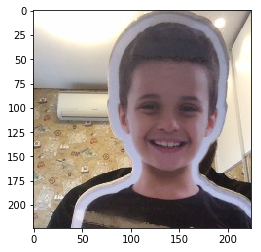

best_prob_index: 
1
classes: 
['books', 'faces', 'remotes']
Result:
[0.08458714932203293, 0.8250940442085266, 0.09031879901885986]
faces
('faces', 0.8250940442085266)

Faces Example - Gabi


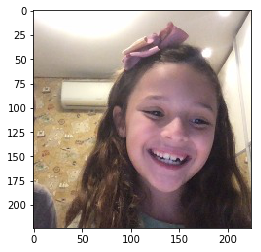

best_prob_index: 
1
classes: 
['books', 'faces', 'remotes']
Result:
[0.08557064086198807, 0.8534391522407532, 0.060990218073129654]
faces
('faces', 0.8534391522407532)

Books Example


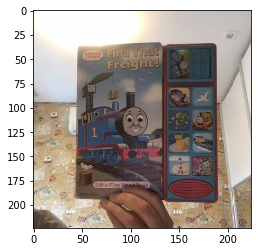

best_prob_index: 
0
classes: 
['books', 'faces', 'remotes']
Result:
[0.6348562240600586, 0.14162340760231018, 0.2235204428434372]
books
('books', 0.6348562240600586)

Remotes Example


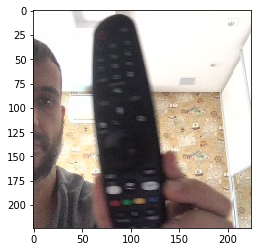

best_prob_index: 
2
classes: 
['books', 'faces', 'remotes']
Result:
[0.05664772912859917, 0.37417182326316833, 0.569180428981781]
remotes
('remotes', 0.569180428981781)


In [13]:
classes_input_var = ["books", "faces", "remotes"]
print("\nFaces Example - Miguel")
display_image('/tmp/andre-dataset/faces/2b5df5f4-d209-4ec3-af1f-9cf21fcb72e5.jpg')
print(classify_deployed("/tmp/andre-dataset/faces/2b5df5f4-d209-4ec3-af1f-9cf21fcb72e5.jpg", classes_input_var))

print("\nFaces Example - Gabi")
display_image('/tmp/andre-dataset/faces/0e09dfb8-4604-441e-8724-af8a0cf2b454.jpg')
print(classify_deployed("/tmp/andre-dataset/faces/0e09dfb8-4604-441e-8724-af8a0cf2b454.jpg", classes_input_var))

print("\nBooks Example")
display_image('/tmp/andre-dataset/books/1be8b224-76a9-432d-b77a-af613a0f46f9.jpg')
print(classify_deployed("/tmp/andre-dataset/books/1be8b224-76a9-432d-b77a-af613a0f46f9.jpg", classes_input_var))

print("\nRemotes Example")
display_image('/tmp/andre-dataset/remotes/0328aab7-5320-4b72-b618-97d73e998451.jpg')
print(classify_deployed("/tmp/andre-dataset/remotes/0328aab7-5320-4b72-b618-97d73e998451.jpg", classes_input_var))

print("\Andre1 Example")
display_image('/tmp/andre-dataset/faces/aboavent1.png')
print(classify_deployed("/tmp/andre-dataset/faces/aboavent1.png", classes_input_var))

print("\Andre2 Example")
display_image('/tmp/andre-dataset/faces/aboavent2.jpeg')
print(classify_deployed("/tmp/andre-dataset/faces/aboavent2.jpeg", classes_input_var))


\Andre1 Example


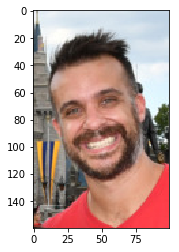

best_prob_index: 
1
classes: 
['books', 'faces', 'remotes']
Result:
[0.0378611795604229, 0.9423885941505432, 0.019750136882066727]
faces
('faces', 0.9423885941505432)
\Andre2 Example


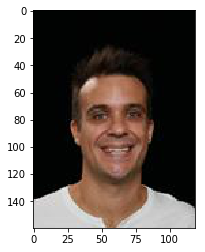

best_prob_index: 
1
classes: 
['books', 'faces', 'remotes']
Result:
[0.0881294384598732, 0.749965488910675, 0.16190505027770996]
faces
('faces', 0.749965488910675)


\Andre Example


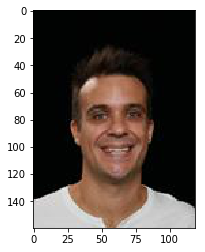

best_prob_index: 
1
classes: 
['books', 'faces', 'remotes']
Result:
[0.0881294384598732, 0.749965488910675, 0.16190505027770996]
faces
('faces', 0.749965488910675)


In [17]:
print("\Andre Example")
display_image('/tmp/andre-dataset/faces/aboavent2.jpeg')
print(classify_deployed("/tmp/andre-dataset/faces/aboavent2.jpeg", classes_input_var))

## (Optional) Perform Hyperparameter Tuning

Often, you might not know which values for hyperparameters like `learning_rate` and `mini_batch_size` will yield acceptible results. Traditionally, this meant manually running many training jobs with different hyperparameter values, looking at each trained model's performance, and then picking a winner. 

This type of manual tuning is _very_ time consuming, so you can automate this process using automatic model tuning with SageMaker. Here's some example code to illustrate how to start one of these jobs using the SageMaker Python SDK.

More info here about automatic model tuning: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html

More info about model tuning for the Image Classification algorithm: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-tuning.html

In [16]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
hyperparameter_ranges = {'optimizer': CategoricalParameter(['sgd', 'adam']),
                         'learning_rate': ContinuousParameter(0.0001, 0.1),
                         'mini_batch_size': IntegerParameter(2, 32),
                        }

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(image_classifier,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=50,
                            max_parallel_jobs=2)

tuner.fit(inputs=data_channels, logs=True, include_cls_metadata=False)

## Great resources to continue your Deep Learning journey

[3Blue1Brown’s YouTube series on Neural Networks ~ 60 Minutes](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

[Fast.ai’s Practical Deep Learning for Coders ~ 14 Hours](http://www.fast.ai/)
    
[Amazon's Machine Learning University ~ More than 45 hours of courses, videos, and labs](https://aws.amazon.com/training/learning-paths/machine-learning/)
    
[Neural Networks and Deep Learning, by Michael Neilsen ~ 6 Chapter Book](http://neuralnetworksanddeeplearning.com/)

[Amazon SageMaker - Fully-managed Platform](https://aws.amazon.com/sagemaker/)
    
[@gabehollombe's](https://twitter.com/gabehollombe) deep learning tools and demos
- [Jupyter Notebooks](https://github.com/gabehollombe-aws/jupyter-notebooks)
- [Webcam S3 Uploader Tool](https://github.com/gabehollombe-aws/webcam-s3-uploader)
- [SageMaker Inference Web Tool](https://github.com/gabehollombe-aws/webcam-sagemaker-inference)
